In [1796]:
using RobotZoo
using RobotDynamics
using LinearAlgebra
using StaticArrays
using SparseArrays
using MeshCat, GeometryBasics, Colors, CoordinateTransformations, Rotations
using Plots

In [1797]:
const RD = RobotDynamics

RobotDynamics

In [1798]:
include("visualization.jl")

visualize! (generic function with 1 method)

In [1799]:
function create_U(num_knots, m, U_type::String)

    if U_type == "constant"
        u0 = 2 .* ones(m)
    elseif U_type == "random"
        u0 = 0.01 .* ones(m)
    end

    U = [u0]

    for k in 1:(num_knots-1)

        if U_type == "constant"
            u = 2 .* ones(m)
        elseif U_type == "random"
            u = -5 .+ (10*rand(Float64, m))
        end

        push!(U, u)

    end
    
    return U

end

create_U (generic function with 1 method)

In [1800]:
function create_training_U(num_knots, m)

    u0 = -3 .* ones(m)
    U = [u0]

    for k in 1:(num_knots-1)

        u = -3 .+ (6*rand(Float64, m))
        push!(U, u)

    end

    # for k in (Int(round((num_knots-1)/2) + 1)) : (num_knots - 1)

    #     u = 2 .* ones(m)
    #     push!(U, u)
    # end
    
    # return U

    # for k in 1 : (Int(round((num_knots-1)/2)))

    #     u = 2 .* ones(m)
    #     push!(U, u)
    # end

    # for k in (Int(round((num_knots-1)/2) + 1)) : (num_knots - 1)

    #     u = -2 .* ones(m)
    #     push!(U, u)
    # end
    
    return U

end

create_training_U (generic function with 1 method)

In [1801]:
function simulate(dmodel, x0, U, dt)

    t = 0.0
    x = x0
    X = [x]
    T = [t]
    
    for k in 1:length(U)

        u = U[k]
        x = RD.discrete_dynamics(dmodel, x, u, t, dt)
        t += dt
        push!(X, x)
        append!(T, t)

    end

    return T, X

end

simulate (generic function with 1 method)

In [1802]:
function chebyshev_poly(x, order=5)
    
    T0 = ones(length(x))
    T1 = x

    chebyshev = [T0]
    push!(chebyshev, T1)

    for p in 2:order

        next_T = (2 .* x .* chebyshev[p]) - chebyshev[p-1]
        push!(chebyshev, next_T)

    end

    chebyshev = reduce(vcat, chebyshev[2:end])

    return chebyshev
    
end

chebyshev_poly (generic function with 2 methods)

In [1803]:
function hermite_poly(x, order=5)
    
    T0 = ones(length(x))
    T1 = 2 .* x

    hermite = [T0]
    push!(hermite, T1)

    for p in 2:order

        next_T = (2 .* x .* hermite[p]) - 2 .* p .* hermite[p-1]
        push!(hermite, next_T)

    end

    hermite = reduce(vcat, hermite[2:end])

    return hermite
    
end

hermite_poly (generic function with 2 methods)

In [1804]:
function create_poly(x, order=5)

    poly_x = [x]

    for p in 2:order

        push!(poly_x, x .^ p)

    end

    return poly_x
    
end

create_poly (generic function with 2 methods)

In [1805]:
function koopman_eigenfunctions(X, U, x0, order)

    n = length(X[1])
    num_p = 2*n*order
    Z = []
    Zu = []
    
    for k in 1:length(X)
        
        xk = X[k]
        zk = vcat([1], xk, sin.(xk), cos.(xk))
        push!(Z, zk)

        if k < length(X)
            uk = U[k]
            zu = vcat(zk, vec(zk*uk'))
            push!(Zu, zu)
        end

    end

return Z, Zu

end

koopman_eigenfunctions (generic function with 2 methods)

In [1806]:
function simulate_bilinear(F, C, g, x0, z0, U)
    
    x = x0
    z = z0
    Z = [z]
    X = [x]

    for k in 1:length(U)

        u = U[k]

        z = F * z + (C * z) .* u
        x = g * z

        push!(Z, z)
        push!(X, x)
        
    end

    return X, Z

end

simulate_bilinear (generic function with 1 method)

In [1807]:
# define temporal properties
dt = 0.01
tf = 3

num_knots = Int(tf/dt + 1)

# define pendulum initial properties
x0 = [0.4*pi, 0]

# define Pendulum model
model = RobotZoo.Pendulum()

RobotZoo.Pendulum{Float64, 3}(1.0, 0.5, 0.1, 0.5, 0.25, 9.81, ForwardDiff.JacobianConfig{Nothing, Float64, 3, Tuple{Vector{ForwardDiff.Dual{Nothing, Float64, 3}}, Vector{ForwardDiff.Dual{Nothing, Float64, 3}}}}((Partials(1.0, 0.0, 0.0), Partials(0.0, 1.0, 0.0), Partials(0.0, 0.0, 1.0)), (ForwardDiff.Dual{Nothing, Float64, 3}[Dual{Nothing}(1.5178e-319,4.94e-322,4.94e-321,1.235e-321), Dual{Nothing}(1.0e-322,1.5e-323,1.6e-322,2.0e-323)], ForwardDiff.Dual{Nothing, Float64, 3}[Dual{Nothing}(1.0e-323,5.0e-324,0.0,5.0e-324), Dual{Nothing}(1.0e-323,5.0e-324,0.0,5.0e-324), Dual{Nothing}(5.0e-324,5.0e-324,0.0,6.92758258826245e-310)])), FiniteDiff.JacobianCache{Vector{Float64}, Vector{Float64}, Vector{Float64}, UnitRange{Int64}, Nothing, Val{:forward}(), Float64}([0.0, 0.0, 0.0], [0.0, 0.0], [0.0, 0.0], 1:3, nothing))

In [1808]:
state_dim(model) = 2
control_dim(model) = 1

dmodel = RD.DiscretizedDynamics{RD.RK4}(model)
n, m = RD.dims(dmodel)

# create predefined control trajectory
U_sim = create_training_U(num_knots, m)

# randomly simulate model and store trajectory
time, X_sim = simulate(dmodel, x0, U_sim, dt)

([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.07, 0.08, 0.09  …  2.9199999999999817, 2.9299999999999815, 2.9399999999999813, 2.949999999999981, 2.959999999999981, 2.9699999999999807, 2.9799999999999804, 2.9899999999999802, 2.99999999999998, 3.00999999999998], [[1.2566370614359172, 0.0], [1.2551061944757564, -0.305953936820147], [1.2514567524162816, -0.4238186500660824], [1.245832319445029, -0.7008250633999387], [1.237974574643778, -0.870527783787643], [1.2288990767585208, -0.9444243095252401], [1.2189804385343328, -1.0391299536443197], [1.2081916572946891, -1.1184500683840632], [1.1961976976075113, -1.2800928121757327], [1.1829818704567903, -1.3628566779901956]  …  [0.6677684836592856, 1.8248975908531102], [0.6852965726265402, 1.6803696708936122], [0.7018287585340466, 1.6256883061337046], [0.7171484993954629, 1.4380049420732746], [0.731133060298517, 1.3586176524368911], [0.7437777250537896, 1.1701349175336444], [0.7545158905761176, 0.9773695763389983], [0.763826901343588

In [1809]:
global vis = Visualizer()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8916
└ @ MeshCat /home/jeonghun/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8916))

In [1810]:
visualize!(vis, model, tf, X_sim)

In [1811]:
# calculate koopman data matrices
Z_sim, Zu_sim = koopman_eigenfunctions(X_sim, U_sim, order)

# convert data matrices into actual matrix arrays from vectors of vectors
X_mat = mapreduce(permutedims, vcat, X_sim)'
U_mat = mapreduce(permutedims, vcat, U_sim)'
Z_mat = mapreduce(permutedims, vcat, Z_sim)'
Zu_mat = mapreduce(permutedims, vcat, Zu_sim)'

# extract data matrices
Z = Z_mat[:, 1:end-1]
Z_prime = Z_mat[:, 2:end]
Zu = Zu_mat
X = X_mat[:, 1:end-1]

z0 = Z[:, 1]

num_eigenfunctions = size(Z)[1]

# perform LLS
A = Z_prime*pinv(Zu)
g = X*pinv(Z)

F = A[:, 1:size(A)[1]]
C = A[:, (size(A)[1] + 1):end]

7×7 Matrix{Float64}:
 -1.92121e-16  -1.25594e-15   9.38919e-17  …  -2.01228e-16   1.0842e-16
  0.000199754  -2.56497e-7    1.18324e-8      -8.42351e-8    9.30094e-9
  0.039926     -7.68173e-5    3.57183e-6      -2.81078e-5    2.97874e-6
 -5.45623e-5    0.000782049  -3.69444e-5       0.00034525   -3.42651e-5
 -0.0229655     0.0190988     0.000879505      0.0333208     0.0515234
 -0.00114888    0.0043584     0.00014861   …   0.00201284    0.000714782
 -0.00539584    0.00199502    0.000182448      0.0012722    -0.00470317

In [1812]:
bi_X, _ = simulate_bilinear(F, C, g, x0, z0, U_sim)
bi_X_mat = mapreduce(permutedims, vcat, bi_X)'

2×302 adjoint(::Matrix{Float64}) with eltype Float64:
 1.25664   1.25511    1.25145    1.24581   …  0.744905  0.752551  0.758367
 0.0      -0.306244  -0.424861  -0.702989     0.847991  0.681184  0.481987

In [1813]:
global vis = Visualizer()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8917
└ @ MeshCat /home/jeonghun/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8917))

In [1814]:
visualize!(vis, model, tf, bi_X)
#visualize!(vis, model, tf, X_sim)

In [1815]:
# extract individual state histories
theta_sim = X_mat[1, :]
omega_sim = X_mat[2, :]

theta_bilinear = bi_X_mat[1, :]
omega_bilinear = bi_X_mat[2, :]

302-element Vector{Float64}:
  0.0
 -0.3062437356093122
 -0.4248612026373672
 -0.7029887646661798
 -0.8741032715472624
 -0.949506619755259
 -1.045725236086521
 -1.1265350408030321
 -1.2896514064800113
 -1.37382451216043
 -1.6132562954723284
 -1.748777025917623
 -1.9597183932211066
  ⋮
  1.9914032754058175
  1.9168481816764003
  1.730262409407632
  1.5940560141944025
  1.547709470672357
  1.3683469871869098
  1.297252049598396
  1.117027549146659
  0.9324810776437544
  0.8479913939476726
  0.6811841021804766
  0.48198671609006266

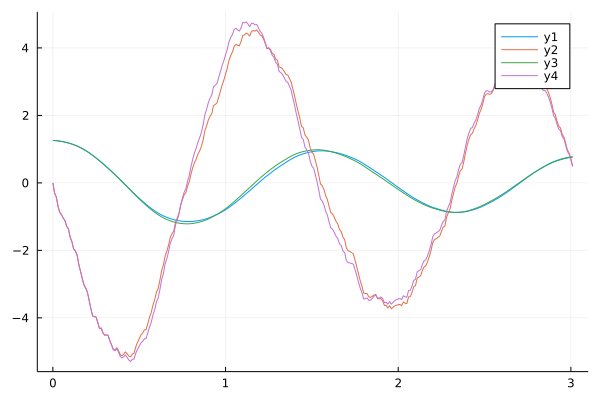

In [1816]:
plot(time, theta_sim)
plot!(time, omega_sim)

plot!(time, theta_bilinear)
plot!(time, omega_bilinear)

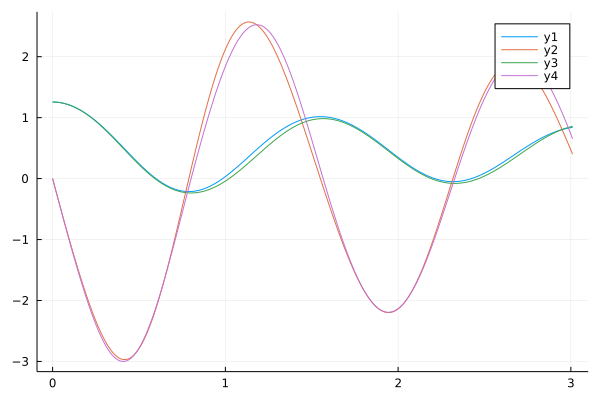

In [1817]:
U_test = create_U(num_knots, m, "constant")

time_test, X_test = simulate(dmodel, x0, U_test, dt)
X_test_mat = mapreduce(permutedims, vcat, X_test)'

bi_X_test, _ = simulate_bilinear(F, C, g, x0, z0, U_test)
bi_X_test_mat = mapreduce(permutedims, vcat, bi_X_test)'

# extract individual state histories
theta_test_sim = X_test_mat[1, :]
omega_test_sim = X_test_mat[2, :]

theta_test_bilinear = bi_X_test_mat[1, :]
omega_test_bilinear = bi_X_test_mat[2, :]

plot(time_test, theta_test_sim)
plot!(time_test, omega_test_sim)

plot!(time_test, theta_test_bilinear)
plot!(time_test, omega_test_bilinear)

In [1820]:
using FileIO, JLD2

FileIO.save("pendulum_eDMD_data.jld2", "F", F, "C", C, "g", g, "X_sim", X_sim, "U_sim", U_sim)